# Clustering Users by Age and Gender

### Environment

The directory structure for this notebook is as follows:

- root
    - group
        - Clustering Users by Demographics.ipynb
        - users_clustered.csv (will output at the end of the notebook)
    - ml-100k
        - u.user

### Introduction

In this Jupyter notebook, we build a k-means clustering model based a user age and gender. Once we have a clustering model, we can use it to categorize each user into a cluster. An ALS recommendation model will then be built, narrowing the population of all users in the data set to a sample belonging to the same user cluster as the person of interest.

To begin our cluster modeling, we import a few necessary pacakges from `pyspark`. Please ensure you have `pyspark` loaded in the virtual environment used to run this notebook. If your receive an error message telling you there is no module named `pyspark`, please see this [Stack Overflow](https://stackoverflow.com/questions/34302314/no-module-name-pyspark-error/34347373) post to help troubleshoot. Just make sure that if you are using anaconda, you install `pyspark` with `conda install pyspark`.

In [1]:
# load matplotlib dependencies
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# load pyspark dependencies
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

### The Setup

Before we can do anything with Spark, we must instantiate our session. Additionally, we will grab the Spark context from the session to help with importing the user data.

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("UserClustering").getOrCreate()

# get the Spark context
sc = spark.sparkContext

Next, we define a mapping function to help code the user's gender while we import the data into the Spark context. Then, we read the `u.user` file.

In [3]:
# define a function to read in users
def mapper(line):
    fields = line.split("|")
    return (int(fields[0]), int(fields[1]), fields[2], fields[3])
    
# gett the user text file
rdd = sc.textFile("../ml-100k/u.user").map(mapper)

We currently have an RDD containing our users' age and gender (represented by 0s and 1s). In order to use the KMeans clustering methods in Spark, we need our data arranged as a DataFrame. Since our user data file did not have headers, we specify a schema before creating the user DataFrame.

In [4]:
# build the user schema
userSchema = StructType([ \
             StructField("UserId", IntegerType(), True), \
             StructField("Age", IntegerType(), True), \
             StructField("Gender", StringType(), True), \
             StructField("Occupation", StringType(), True)])

# convert the RDD to a DataFrame with the user schema
users = spark.createDataFrame(rdd, userSchema)

# show the first 5 rows of the users DataFrame
users.show(5)

+------+---+------+----------+
|UserId|Age|Gender|Occupation|
+------+---+------+----------+
|     1| 24|     M|technician|
|     2| 53|     F|     other|
|     3| 23|     M|    writer|
|     4| 24|     M|technician|
|     5| 33|     F|     other|
+------+---+------+----------+
only showing top 5 rows



### K-Means Clustering

In order to run the KMeans algorithm, `pyspark` needs numerical values, so we need to convert the Gender and Occupation fields to numerical values. Further, since they are categorical, we will one-hot encode them. We will use instances of `StringIndexer` and `OneHotEncoder` to accomplish these tasks. Additionally, `pyspark` expects the features to be bundled into a single vector. To accomplish this task, we create an instance of `VectorAssembler`. Finally, we put all the pieces together as a `Pipeline` object.

In [5]:
# define a function to collapse all features into a single feature vector
# indexes categorical variables then one-hot encodes them
def collapse_features(df, idCol, catCols, numCols):
    indexers = [StringIndexer(inputCol = catCol, outputCol = f"{catCol}Indexed") for catCol in catCols]
    
    encoders = [OneHotEncoder(inputCol = indexer.getOutputCol(), outputCol = f"{indexer.getOutputCol()}Encoded") for indexer in indexers]
    
    assembler = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders] + numCols, outputCol = "features")
    
    pipeline = Pipeline(stages = indexers + encoders + [assembler])
    
    model = pipeline.fit(df)
    data = model.transform(df)
    
    return data.select(idCol, "features")

# collapse age, gender, and occupation into a single feature vector for each user
users = collapse_features(users, "UserId", ["Gender", "Occupation"], ["Age"])

# show the first 5 rows of the users DataFrame
users.show(5)

+------+--------------------+
|UserId|            features|
+------+--------------------+
|     1|(22,[0,12,21],[1....|
|     2|(22,[2,21],[1.0,5...|
|     3|(22,[0,8,21],[1.0...|
|     4|(22,[0,12,21],[1....|
|     5|(22,[2,21],[1.0,3...|
+------+--------------------+
only showing top 5 rows



Now that our user age and gender values are bundled into feature vectors, we can use the KMeans algorithm in Spark. Rather than guess a single value for $k$, we will perform the modeling over the range $2 \leq k \leq 10$. To evaluate our models and determine the most reasonable value for $k$, we use a `ClusteringEvaluator` to minimize the squared Euclidean distance between points in each cluster.

**This may take quite a bit of time to run**

In [6]:
# create an empty list to hold the silhouette scores for each model run
silhouette_scores = []

# create an evaluator to score each model run
evaluator = ClusteringEvaluator( \
    predictionCol = "prediction", \
    featuresCol = "features", \
    metricName = "silhouette", \
    distanceMeasure = "squaredEuclidean" \
)

# run the KMeans algorithm for k in [2, 10]
for i in range(2, 11):
    
    # set the model parameters
    kmeans = KMeans(featuresCol = "features", k = i).setSeed(123)
    
    # fit the model to the users DataFrame
    fit = kmeans.fit(users)
    
    # create a new DataFrame with the user clusters
    output = fit.transform(users)
    
    # evaluate the output using the ClusteringEvaluator
    score = evaluator.evaluate(output)
    
    # add the model's silhouette score to the list
    silhouette_scores.append(score)

### Visualize the Silhouette Scores
Rather than view a table of values, we visualize the silhouette scores using `matplotlib`.

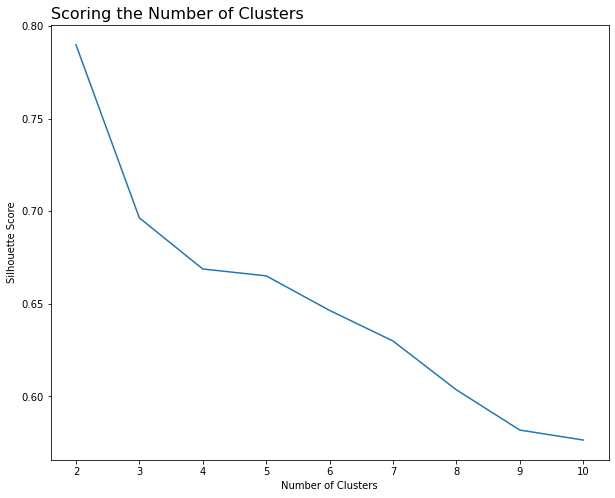

In [7]:
# visualize the silhouette scores
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
ax.plot(range(2, 11), silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title("Scoring the Number of Clusters", fontsize = 16, loc = "left")

x_ax = ax.axes.get_xaxis()
x_ax.set_major_locator(MaxNLocator(integer=True))

### Clustered the Users

Examining the plot above shows that $k = 3$ clusters is the local maximum silhouette score. Thus we will cluster the users into four groups using their age, gender and occupation, creating a new DataFrame with the clustering attached. Finally, we save the clustered users DataFrame as a CSV for consumption in the recommender application.

In [8]:
# set the model parameters
kmeans = KMeans(featuresCol = "features", k = 3).setSeed(123)
    
# fit the model to the users DataFrame
fit = kmeans.fit(users)
    
# create a new DataFrame with the user clusters
users_clustered = fit.transform(users).select("UserId", "Prediction").withColumnRenamed("Prediction", "Cluster")

In [9]:
# show the first 5 rows of the clustered users DataFrame
users_clustered.show(5)

+------+-------+
|UserId|Cluster|
+------+-------+
|     1|      2|
|     2|      1|
|     3|      2|
|     4|      2|
|     5|      0|
+------+-------+
only showing top 5 rows



In [10]:
# save the clustered users DataFrame as a CSV for use in the recommender application
users_clustered.toPandas().to_csv("users_clustered.csv", index = False)